In [2]:
import os, json, math, textwrap, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import plotly.express as px
from pathlib import Path
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook")

In [3]:
# Paths (ajusta si fuera necesario)
BASE_DIR = Path.cwd()  # directorio actual del notebook
DATA_DIR = BASE_DIR / "initial_data"  # <- asegúrate que coincide con tu estructura
assert DATA_DIR.exists(), f"No encuentro la carpeta: {DATA_DIR}"

In [4]:
def load_function_data(func_dir: Path):
    """Load inputs and outputs .npy from function_k folder. 
    Admite que .npy pueda almacenar dict o arrays crudos."""
    inputs_path = func_dir / "initial_inputs.npy"
    outputs_path = func_dir / "initial_outputs.npy"
    assert inputs_path.exists(), f"Falta {inputs_path}"
    assert outputs_path.exists(), f"Falta {outputs_path}"
    
    X = np.load(inputs_path, allow_pickle=True)
    y = np.load(outputs_path, allow_pickle=True)
    # Si vienen como dicts con claves {'x', 'y'}
    if isinstance(X, dict): X = X.get("x", X.get("inputs", None))
    if isinstance(y, dict): y = y.get("y", y.get("outputs", None))
    X = np.array(X)
    y = np.array(y).reshape(-1)
    return X, y

def describe_xy(X, y):
    n, d = X.shape
    desc = {
        "n_samples": n,
        "n_dims": d,
        "y_min": float(np.min(y)),
        "y_max": float(np.max(y)),
        "y_mean": float(np.mean(y)),
        "y_std": float(np.std(y)),
        "x_min": X.min(axis=0).tolist(),
        "x_max": X.max(axis=0).tolist(),
    }
    return desc

def print_description(func_name, desc):
    print(f"== {func_name} ==")
    print(f"Samples: {desc['n_samples']}, Dims: {desc['n_dims']}")
    print(f"y: min={desc['y_min']:.4f}  max={desc['y_max']:.4f}  mean={desc['y_mean']:.4f}  std={desc['y_std']:.4f}")
    print(f"x_min: {[round(v,4) for v in desc['x_min']]}")
    print(f"x_max: {[round(v,4) for v in desc['x_max']]}")

In [5]:
# Cargar todas las funciones encontradas en initial_data/
FUNC_DIRS = sorted([p for p in DATA_DIR.iterdir() if p.is_dir() and p.name.startswith("function_")],
                   key=lambda p: int(p.name.split("_")[1]))

data_dict = {}
for p in FUNC_DIRS:
    try:
        X, y = load_function_data(p)
        data_dict[p.name] = {"X": X, "y": y}
        desc = describe_xy(X, y)
        print_description(p.name, desc)
    except Exception as e:
        print(f"[WARN] Problema con {p.name}: {e}")

== function_1 ==
Samples: 10, Dims: 2
y: min=-0.0036  max=0.0000  mean=-0.0004  std=0.0011
x_min: [0.0825, 0.0787]
x_max: [0.8839, 0.8799]
== function_2 ==
Samples: 10, Dims: 2
y: min=-0.0656  max=0.6112  mean=0.2307  std=0.2254
x_min: [0.1427, 0.0287]
x_max: [0.8778, 0.9266]
== function_3 ==
Samples: 15, Dims: 3
y: min=-0.3989  max=-0.0348  mean=-0.1072  std=0.0842
x_min: [0.0468, 0.2199, 0.0661]
x_max: [0.966, 0.9414, 0.9909]
== function_4 ==
Samples: 30, Dims: 4
y: min=-32.6257  max=-4.0255  mean=-17.2386  std=7.0180
x_min: [0.0378, 0.0063, 0.0422, 0.0815]
x_max: [0.9856, 0.9196, 0.9392, 0.9995]
== function_5 ==
Samples: 20, Dims: 4
y: min=0.1129  max=1088.8596  mean=151.2719  std=245.5760
x_min: [0.1199, 0.0382, 0.0889, 0.0729]
x_max: [0.8365, 0.8625, 0.8795, 0.9576]
== function_6 ==
Samples: 20, Dims: 5
y: min=-2.5712  max=-0.7143  mean=-1.4954  std=0.4490
x_min: [0.0217, 0.1144, 0.0165, 0.0456, 0.0049]
x_max: [0.9577, 0.9319, 0.9788, 0.9617, 0.8928]
== function_7 ==
Samples: 30, 

2) Limpieza, normalización y chequeos

In [6]:
def normalize_xy(X, y, x_method="minmax", y_standardize=True):
    if x_method == "minmax":
        x_scaler = MinMaxScaler()
    elif x_method == "standard":
        x_scaler = StandardScaler()
    else:
        raise ValueError("x_method must be 'minmax' or 'standard'")
    Xn = x_scaler.fit_transform(X)
    if y_standardize:
        y_mean, y_std = np.mean(y), np.std(y) if np.std(y) > 0 else 1.0
        yn = (y - y_mean) / y_std
    else:
        yn = y.copy()
        y_mean, y_std = np.mean(y), np.std(y)
    return Xn, yn, x_scaler, (y_mean, y_std)

def duplicate_rows(X, tol=1e-9):
    """Detect exact duplicates (within tolerance)"""
    # Use rounding to avoid fp glitches
    Xr = np.round(X / tol).astype(np.int64)
    _, idx_inv, counts = np.unique(Xr, axis=0, return_inverse=True, return_counts=True)
    dup_mask = counts[idx_inv] > 1
    return dup_mask, counts

def min_pairwise_distance(X):
    from scipy.spatial.distance import pdist
    if len(X) < 2: return np.inf
    return pdist(X, metric="euclidean").min()

def local_noise_estimate(X, y, k=3):
    """Rough local noise estimate by kNN residual variance."""
    nn = NearestNeighbors(n_neighbors=min(k+1, len(X)))
    nn.fit(X)
    dists, idxs = nn.kneighbors(X)
    # exclude self index at position 0
    residuals = []
    for i in range(len(X)):
        nbrs = idxs[i, 1:]  # neighbors only
        residuals += list(np.abs(y[i] - y[nbrs]))
    return float(np.median(residuals)), float(np.mean(residuals))

In [7]:
# Aplicar chequeos por función
summary_rows = []
for fname, d in data_dict.items():
    X, y = d["X"], d["y"]
    dup_mask, counts = duplicate_rows(X)
    min_dist = min_pairwise_distance(X)
    med_res, mean_res = local_noise_estimate((X - X.min(0))/(X.max(0)-X.min(0)+1e-12), y, k=3)

    summary_rows.append({
        "function": fname,
        "n": len(X),
        "d": X.shape[1],
        "y_min": float(y.min()),
        "y_max": float(y.max()),
        "y_std": float(y.std()),
        "duplicates": int(dup_mask.sum()),
        "min_pair_dist": min_dist,
        "local_noise_med": med_res,
        "local_noise_mean": mean_res,
    })
pd.DataFrame(summary_rows)

,function,n,d,y_min,y_max,y_std,duplicates,min_pair_dist,local_noise_med,local_noise_mean
0,function_1,10,2,-0.003606,7.710875e-16,0.001082,0,0.095895,2.535001e-40,0.001082
1,function_2,10,2,-0.065624,6.112052e-01,0.225365,0,0.074930,2.251680e-01,0.247763
2,function_3,15,3,-0.398926,-3.483531e-02,0.084214,0,0.116268,5.935425e-02,0.070725
3,function_4,30,4,-32.625660,-4.025542e+00,7.017985,0,0.095572,3.941233e+00,5.743897
4,function_5,20,4,0.112940,1.088860e+03,245.575981,0,0.204015,5.398775e+01,133.462401
5,function_6,20,5,-2.571170,-7.142649e-01,0.449000,0,0.323654,3.614224e-01,0.403273
6,function_7,30,6,0.002701,1.364968e+00,0.302129,0,0.179787,8.400298e-02,0.235170
7,function_8,40,8,5.592193,9.598482e+00,0.946903,0,0.377930,5.768885e-01,0.720512


3) Visualización


3.1 Scatter coloreado por y (2D/3D)

In [8]:
def plot_scatter_colored(X, y, title=""):
    d = X.shape[1]
    if d == 2:
        df = pd.DataFrame({"x1": X[:,0], "x2": X[:,1], "y": y})
        fig = px.scatter(df, x="x1", y="x2", color="y", color_continuous_scale="viridis", title=title)
        fig.show()
    elif d == 3:
        df = pd.DataFrame({"x1": X[:,0], "x2": X[:,1], "x3": X[:,2], "y": y})
        fig = px.scatter_3d(df, x="x1", y="x2", z="x3", color="y", color_continuous_scale="viridis", title=title)
        fig.show()
    else:
        print("Use pairplot/PCA for d>=4.")

In [9]:
# Ejemplos para Function 1 (2D) y Function 3 (3D), si existen
for fn in ("function_1", "function_3"):
    if fn in data_dict:
        X, y = data_dict[fn]["X"], data_dict[fn]["y"]
        plot_scatter_colored(X, y, title=f"{fn}: colored by y")

3.2 Pairplot para d≥4 (y también útil en 3D)

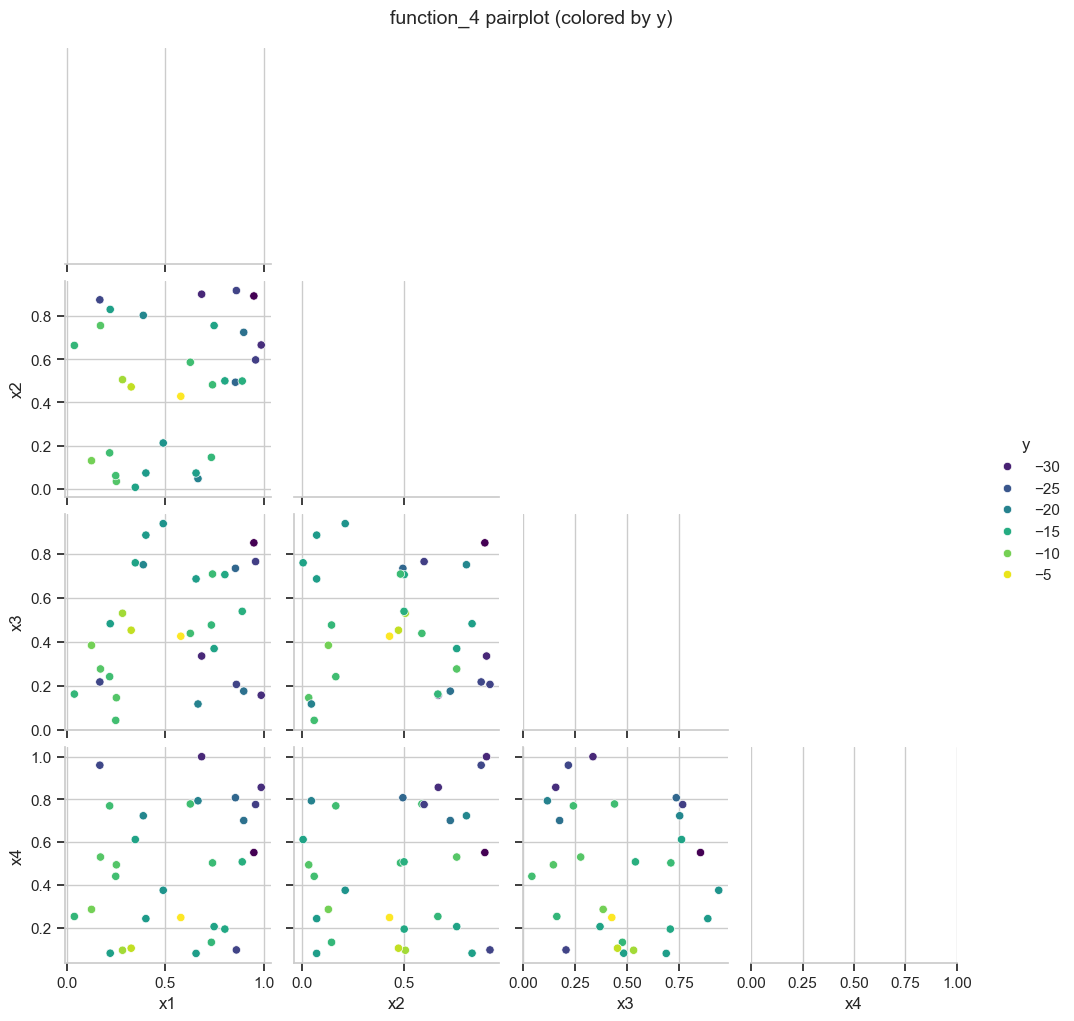

In [10]:
def pairplot_df(X, y, max_points=500, title="Pairplot"):
    n = len(X)
    sel = np.random.choice(n, size=min(n, max_points), replace=False)
    df = pd.DataFrame(X[sel], columns=[f"x{i+1}" for i in range(X.shape[1])])
    df["y"] = y[sel]
    g = sns.pairplot(df, hue="y", diag_kind="kde", corner=True, palette="viridis")
    plt.suptitle(title, y=1.02, fontsize=14)
    plt.show()

# Ejemplo para Function 4 (4D) si existe
if "function_4" in data_dict:
    X, y = data_dict["function_4"]["X"], data_dict["function_4"]["y"]
    pairplot_df(X, y, title="function_4 pairplot (colored by y)")

3.3 PCA a 2D para d≥4

In [11]:
def pca_projection(X, y, title="PCA 2D projection"):
    pca = PCA(n_components=2, random_state=0)
    X2 = pca.fit_transform(X)
    df = pd.DataFrame({"pc1": X2[:,0], "pc2": X2[:,1], "y": y})
    fig = px.scatter(df, x="pc1", y="pc2", color="y", color_continuous_scale="viridis", title=title)
    fig.show()
    print("Explained variance ratio:", pca.explained_variance_ratio_)

# Ejemplo si existe function_7 (6D) y function_8 (8D)
for fn in ("function_7", "function_8"):
    if fn in data_dict:
        X, y = data_dict[fn]["X"], data_dict[fn]["y"]
        pca_projection(X, y, title=f"{fn} PCA 2D (colored by y)")

Explained variance ratio: [0.28287818 0.2574203 ]


Explained variance ratio: [0.2031605  0.20055518]


4) DataFrames, normalización y guardado a CSV

In [12]:
def to_dataframe(X, y):
    df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(X.shape[1])])
    df["y"] = y
    return df

SAVE_DIR = BASE_DIR / "exploration_outputs"
SAVE_DIR.mkdir(exist_ok=True)

for fname, d in data_dict.items():
    X, y = d["X"], d["y"]
    df_raw = to_dataframe(X, y)
    df_raw.to_csv(SAVE_DIR / f"{fname}_raw.csv", index=False)

    Xn, yn, x_scaler, (ym, ys) = normalize_xy(X, y, x_method="minmax", y_standardize=True)
    df_norm = to_dataframe(Xn, yn)
    df_norm.to_csv(SAVE_DIR / f"{fname}_normalized.csv", index=False)

print(f"CSV guardados en: {SAVE_DIR.resolve()}")

CSV guardados en: /Users/marvelo/Documents/ImperialCollege/capstone/exploration_outputs


5) Reglas de envío y ayudantes

In [13]:
def format_submission(x):
    """Formato 'a.bbbbbb - c.dddddd - ...' con 6 decimales y limites [0,1] si trabajas normalizado."""
    vals = [f"{float(v):.6f}" for v in x]
    return " - ".join(vals)

def suggest_candidate_grid(X, y, n_candidates=20000, random_state=0):
    """Genera candidatos Sobol/LatinHypercube-like usando uniform sampling (simple) en el rango observado."""
    rng = np.random.default_rng(random_state)
    lo = X.min(axis=0)
    hi = X.max(axis=0)
    C = rng.random((n_candidates, X.shape[1])) * (hi - lo) + lo
    return C

# Ejemplo con function_1 (si existe)
if "function_1" in data_dict:
    X, y = data_dict["function_1"]["X"], data_dict["function_1"]["y"]
    C = suggest_candidate_grid(X, y, n_candidates=5000, random_state=42)
    # Tomemos el mejor vecino del actual y como demo tonta:
    x_best_idx = np.argmax(y)
    x_best = X[x_best_idx]
    # candidato más cercano a x_best (solo demostración)
    idx = np.argmin(np.linalg.norm(C - x_best, axis=1))
    x_next = C[idx]
    print("Propuesta de formato de envío:")
    print(format_submission(x_next))

Propuesta de formato de envío:
0.739160 - 0.733501


6) Informe rápido por función (resumen automático)

In [14]:
def quick_function_report(fname, X, y):
    print("="*70)
    print(fname)
    desc = describe_xy(X, y)
    print_description(fname, desc)
    dup_mask, _ = duplicate_rows(X)
    print(f"Duplicados: {dup_mask.sum()}")
    print(f"Min pairwise distance: {min_pairwise_distance(X):.4e}")
    med_res, mean_res = local_noise_estimate((X - X.min(0))/(X.max(0)-X.min(0)+1e-12), y, k=3)
    print(f"Ruido local (mediana, media): ({med_res:.4f}, {mean_res:.4f})")
    print()

for fname, d in data_dict.items():
    quick_function_report(fname, d["X"], d["y"])

function_1
== function_1 ==
Samples: 10, Dims: 2
y: min=-0.0036  max=0.0000  mean=-0.0004  std=0.0011
x_min: [0.0825, 0.0787]
x_max: [0.8839, 0.8799]
Duplicados: 0
Min pairwise distance: 9.5895e-02
Ruido local (mediana, media): (0.0000, 0.0011)

function_2
== function_2 ==
Samples: 10, Dims: 2
y: min=-0.0656  max=0.6112  mean=0.2307  std=0.2254
x_min: [0.1427, 0.0287]
x_max: [0.8778, 0.9266]
Duplicados: 0
Min pairwise distance: 7.4930e-02
Ruido local (mediana, media): (0.2252, 0.2478)

function_3
== function_3 ==
Samples: 15, Dims: 3
y: min=-0.3989  max=-0.0348  mean=-0.1072  std=0.0842
x_min: [0.0468, 0.2199, 0.0661]
x_max: [0.966, 0.9414, 0.9909]
Duplicados: 0
Min pairwise distance: 1.1627e-01
Ruido local (mediana, media): (0.0594, 0.0707)

function_4
== function_4 ==
Samples: 30, Dims: 4
y: min=-32.6257  max=-4.0255  mean=-17.2386  std=7.0180
x_min: [0.0378, 0.0063, 0.0422, 0.0815]
x_max: [0.9856, 0.9196, 0.9392, 0.9995]
Duplicados: 0
Min pairwise distance: 9.5572e-02
Ruido local (m